<img src="img/logo.jpg" width="40" height="40"></img>
`python-for-data-analysis-solution.ipynb`, `flu_consultation_records.csv` and `patient_demographics.csv` (10 September, 2021) is provided to NHS England under licence from Faculty Science Ltd.

# Predicting flu consultation
---
There are two relevant datasets:

 `patient_demographics.csv` contains the demographics of the patient (age, gender, ethnicity and who this patient lives with)
 
`flu_consultation_records.csv` contains 735660 rows and 4 columns

   - `date`: the date of the record
   - `temperature`: the average temperature near the patient's home
   - `patient_id`: pseudonymised patient id
   - `has_flu_consultation`: whether the patient has a flu consultation on that day
 
The goal here is to find out whether we can predict a patient is going to make a flu consultation based on the features we have access to.

<i>Note: The data for this exercise has been generated randomly, so may display some regularity that would not be expected of real world data</i>

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# set this to the number of CPU you want to use
n_jobs = 4

## Data
---
Let's load the two datasets and see what is in there

In [3]:
# load the two datasets
demo_df = pd.read_csv(
    "./patient_demographics.csv"
)
flu_df = pd.read_csv(
    "./flu_consultation_records.csv"
)

In [4]:
# return the first 5 rows of demo_df
demo_df.head()

,patient_id,gender,ethnicity,living_condition,age
0,dd0f2ed4-e304-4bc5-b294-dc6857f6fc0d,M,White,other,37.0
1,608454f5-98aa-42ce-b5f4-285cd9b09980,M,White,other,54.0
2,d6bf2b0c-3cd7-4ed6-b3cf-afe074c67894,M,White,other,20.0
3,e8404409-e5e9-4dfe-86da-36cf47c5751f,F,White,other,63.0
4,98d2f9d5-2a7d-49d2-b5f1-8c72325a08cb,F,White,other,26.0


In [5]:
# return the first 5 rows of flu_df
flu_df.head()

,date,temperature,patient_id,has_flu_consultation
0,2020-01-01,6.700850,dd0f2ed4-e304-4bc5-b294-dc6857f6fc0d,no
1,2020-01-02,6.699768,dd0f2ed4-e304-4bc5-b294-dc6857f6fc0d,no
2,2020-01-03,6.698431,dd0f2ed4-e304-4bc5-b294-dc6857f6fc0d,yes
3,2020-01-04,6.700928,dd0f2ed4-e304-4bc5-b294-dc6857f6fc0d,no
4,2020-01-05,6.699303,dd0f2ed4-e304-4bc5-b294-dc6857f6fc0d,no


### Merge data
In order to relate the patient demographics with their flu consultation records, we need to merge the two datasets

In [7]:
# Merge the dataset here
df = pd.merge(demo_df, flu_df, on="patient_id")
df.head()

,patient_id,gender,ethnicity,living_condition,age,date,temperature,has_flu_consultation
0,dd0f2ed4-e304-4bc5-b294-dc6857f6fc0d,M,White,other,37.0,2020-01-01,6.700850,no
1,dd0f2ed4-e304-4bc5-b294-dc6857f6fc0d,M,White,other,37.0,2020-01-02,6.699768,no
2,dd0f2ed4-e304-4bc5-b294-dc6857f6fc0d,M,White,other,37.0,2020-01-03,6.698431,yes
3,dd0f2ed4-e304-4bc5-b294-dc6857f6fc0d,M,White,other,37.0,2020-01-04,6.700928,no
4,dd0f2ed4-e304-4bc5-b294-dc6857f6fc0d,M,White,other,37.0,2020-01-05,6.699303,no


## Exploratory data analysis (EDA)
---

Check for missing values or duplicate rows using pandas and remove accordingly if any are found

In [8]:
print(f"Are there any Null values: {df.isnull().values.any()}")
print(f'Number of duplicated rows: {sum(df.duplicated(keep="first"))}')
df.drop_duplicates(keep="first", inplace=True)
df.dropna(inplace=True)
print(f'Number of rows in the data: {len(df)}')

Are there any Null values: True
Number of duplicated rows: 9941
Number of rows in the data: 689485


Conduct some basic checks on each column to see if there are erroneous data entries, remove them accordingly

In [9]:
df.describe()

,age,temperature
count,689485.000000,689485.000000
mean,36.523430,10.205085
std,21.508303,3.729065
min,-53.000000,4.298284
25%,18.000000,6.798310
50%,37.000000,9.401538
75%,54.000000,14.296907
max,74.000000,15.901695


In [10]:
df = df[df["age"] > 0]


In [13]:
df.describe()
df.head()
pd.to_datetime(df['date']).dt.weekday

0         2
1         3
2         4
3         5
4         6
         ..
742975    6
742976    0
742977    1
742978    2
742979    3
Name: date, Length: 688021, dtype: int64

Visualise the data for better understanding

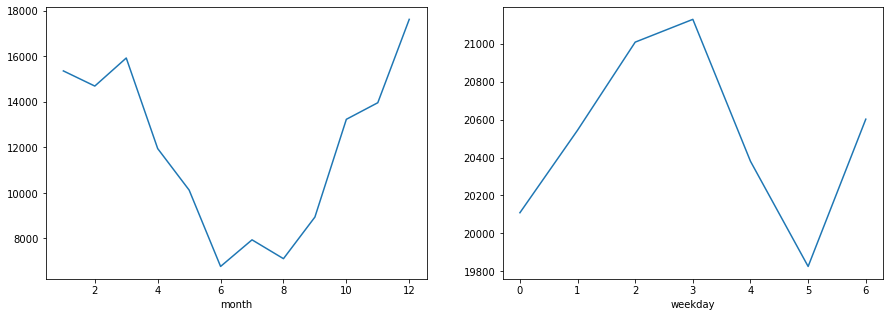

In [14]:
# look at whether the number of flu consultation in each month/ weekday
df['weekday']=pd.to_datetime(df['date']).dt.weekday
df['month']=pd.to_datetime(df['date']).dt.month
df['has_flu_consultation'].replace({'yes':1,'no':0},inplace=True)
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15,5))
flu_consultation_by_month=df.groupby('month')['has_flu_consultation'].sum()
flu_consultation_by_month.plot(ax=ax1)
flu_consultation_by_weekday=df.groupby('weekday')['has_flu_consultation'].sum()
flu_consultation_by_weekday.plot(ax=ax2)

Text(0, 0.5, 'temperature')

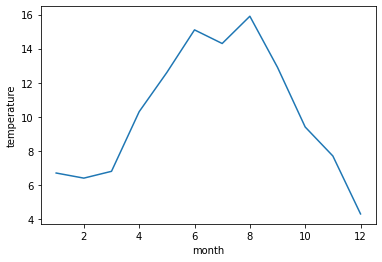

In [16]:
# check the average temperature for each month
temperature_by_month_mean = df.groupby('month').temperature.mean()
plt.plot(temperature_by_month_mean.index,temperature_by_month_mean.values)
plt.xlabel('month')
plt.ylabel('temperature')

In [17]:
temperature_by_month_mean

month
1      6.699803
2      6.400167
3      6.799879
4     10.299700
5     12.600026
6     15.100200
7     14.300303
8     15.899996
9     12.900142
10     9.400011
11     7.699767
12     4.299976
Name: temperature, dtype: float64

In [15]:
df.head()

,patient_id,gender,ethnicity,living_condition,age,date,temperature,has_flu_consultation,weekday,month
0,dd0f2ed4-e304-4bc5-b294-dc6857f6fc0d,M,White,other,37.0,2020-01-01,6.700850,0,2,1
1,dd0f2ed4-e304-4bc5-b294-dc6857f6fc0d,M,White,other,37.0,2020-01-02,6.699768,0,3,1
2,dd0f2ed4-e304-4bc5-b294-dc6857f6fc0d,M,White,other,37.0,2020-01-03,6.698431,1,4,1
3,dd0f2ed4-e304-4bc5-b294-dc6857f6fc0d,M,White,other,37.0,2020-01-04,6.700928,0,5,1
4,dd0f2ed4-e304-4bc5-b294-dc6857f6fc0d,M,White,other,37.0,2020-01-05,6.699303,0,6,1


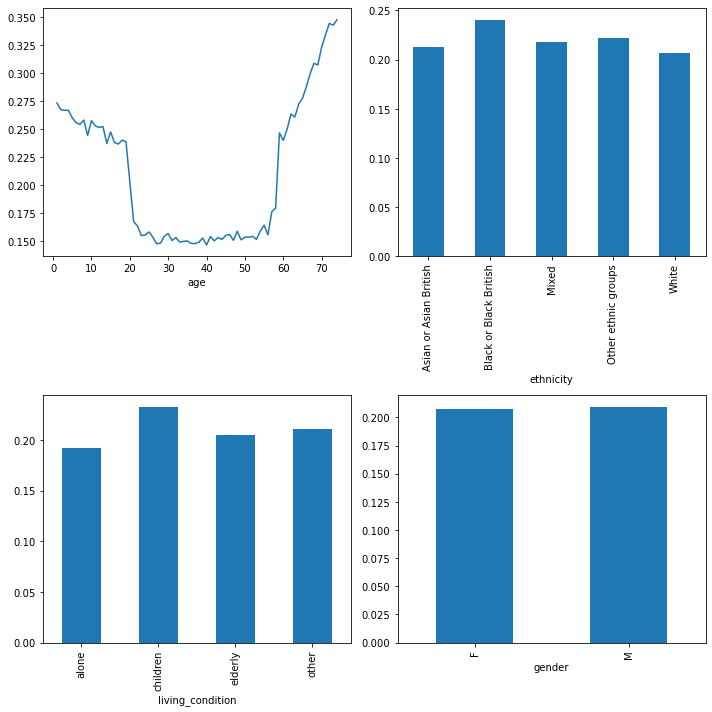

In [12]:
# the number of consultation by demographics
fig, ax = plt.subplots(2, 2, figsize=(10,10))
flu_consulation_by_age = df.groupby('age')['has_flu_consultation'].mean()
flu_consulation_by_age.plot(ax=ax[0,0])
flu_consulation_by_ethnicity = df.groupby('ethnicity')['has_flu_consultation'].mean()
flu_consulation_by_ethnicity.plot(ax=ax[0,1],kind='bar')
flu_consulation_by_livcond = df.groupby('living_condition')['has_flu_consultation'].mean()
flu_consulation_by_livcond.plot(ax=ax[1,0],kind='bar')
flu_consulation_by_gender = df.groupby('gender')['has_flu_consultation'].mean()
flu_consulation_by_gender.plot(ax=ax[1,1],kind='bar')
plt.tight_layout()

In [20]:
    flu_consulation_by_ethnicity = df.groupby('ethnicity')['has_flu_consultation'].count()

What have you learned from these plots? Do you already have some insights about which demographics are more likely to have flu consultation? Are there any features that seem redundant?

##  Preprocessing

In [13]:
# one-hot encode columns that are categorical (hint: pandas has built in functions for this)
categorical_cols = ["ethnicity", "living_condition",'weekday','month']
model_df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

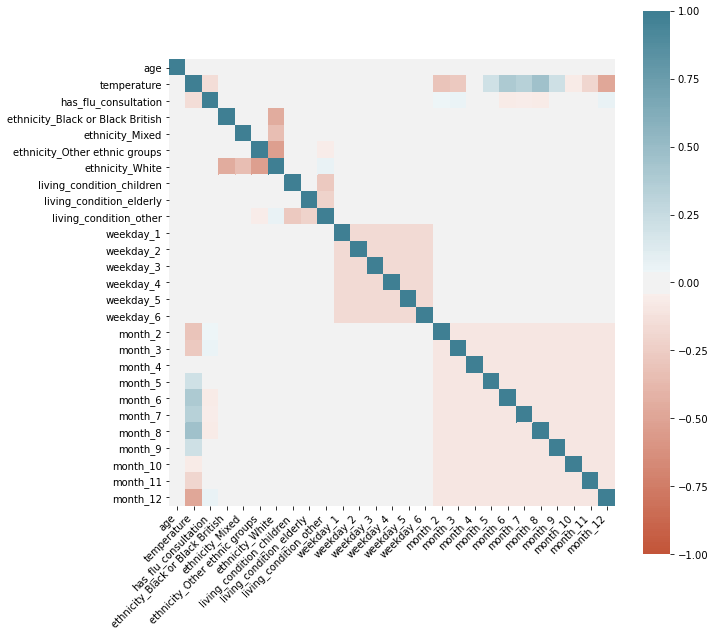

In [14]:
# make some plots to sense-check how correlated are the columns
import seaborn as sns
fig = plt.figure(figsize=(10,10))
ax = sns.heatmap(
    model_df.corr(), 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
_ = ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

In [15]:
# define the columns you wished to include as features
feature_cols = sorted(
    set(model_df.columns) - set(["patient_id", "date", "has_flu_consultation","gender"])
)

In [16]:
# define the outcome variable column
target_col = "has_flu_consultation"

### Train, test, validation split
Before you begin selecting and optimising a machine learning model, you should split your data into train, test (and maybe validation) sets. In some cases, you may only need a training and a validation set. For example, perhaps the test data has been held out from the beginning. You may also choose to just use a train/test split and utilise cross validation methods on your training data. The exact ratios for each dataset will depend on the amount of available data and specifics of the problem but an 80/20 train/test split is a good rule of thumb.

In [17]:
# split the data into train/test sets and separate the features from the target.
from sklearn.model_selection import train_test_split

X = model_df[feature_cols]
y = model_df[target_col]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Model selection and tuning
---
There are many classification algorithms that could be used for this problem. It is up to you to decide which methods are most suitable for this binary classification task given what you have learned about the data so far.In general sklearn can be used to quickly test different types of model. We suggest using cross validation to compare the performance of a few classifiers on the training data, without worrying too much about hyperparameter tuning at this stage. Try to pick at least 3 models that are different in some significant way. Depending on which models you choose, you may need some extra preprocessing steps, e.g., normalising the data. You will need to consider what the important performance metrics are for a classification problem, and use these to decide which model is best for the task.

Note: Is the class of the outcome variable balanced? What can you do to improve the quality of model-fits?

In [18]:
# import the sklearn models that you want to try (recommend 3 models max for time)
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [19]:
lr = LogisticRegression(class_weight='balanced')
y_lr = cross_val_predict(lr, X_train, y_train, cv=4, n_jobs=n_jobs)

In [20]:
dt = DecisionTreeClassifier(class_weight='balanced')
y_dtc = cross_val_predict(dt, X_train, y_train, cv=4, n_jobs=n_jobs)

In [21]:
# train different models using cross validation
rf = RandomForestClassifier(class_weight='balanced')
y_rfc = cross_val_predict(rf, X_train, y_train, cv=4, n_jobs=n_jobs)

In [22]:
# Write a function that takes model predicted probabilities and actual y as input. 
# Compute the accuracy, precision, recall and f1 score
# return a dictionary that has these metrics as keys and the computed metric as values
def get_performance(y_pred, y_true):
    """Returns a dict containing the accuracy, precision, recall, and f1 score of
    a model prediction."""
    # compute performance metrics of model
    performance = {}
    # simple accuracy
    performance["accuracy"] = round(metrics.accuracy_score(y_true, y_pred) * 100, 2)
    # precision
    performance["precision"] = round(metrics.precision_score(y_true, y_pred), 2)
    # recall
    performance["recall"] = round(metrics.recall_score(y_true, y_pred), 2)
    # f1-score
    performance["f1score"] = round(metrics.f1_score(y_true, y_pred), 2)

    return performance

In [23]:
performance_dict = {}
performance_dict["LogReg"] = get_performance(y_lr, y_train)
performance_dict["DecisionTree"] = get_performance(y_dtc, y_train)
performance_dict['RandomForest'] = get_performance(y_rfc, y_train)
df_performance = pd.DataFrame(performance_dict)
df_performance

,LogReg,DecisionTree,RandomForest
accuracy,52.72,59.17,63.39
precision,0.26,0.25,0.26
recall,0.68,0.49,0.41
f1score,0.38,0.33,0.32


Looking at these initial results, which model do you think is best to proceed with? Do you have any thoughts about why a certain model might be performing better at this problem than another. What are the limitations of each model?

## Hyperparameter tuning
---
Select your best model from the above and see if you can increase its performance using hyper parameter tuning. You may find this link helpful. Depending on your model, doing an exhaustive grid search might take a very long time. Consider limiting your grid size by either selecting one or two of the hyperparameters that you think are most important or searching over small value range for each hyper parameter. Alternatively, you could try a randomised grid search to speed things up.

In [24]:
from sklearn.model_selection import GridSearchCV

In [25]:
# Do a grid search on your hyperparameter space.
param_grid = {
    'min_samples_leaf':[10,20,40],
    'max_features':["auto","sqrt"]
             }
clf = RandomForestClassifier(random_state=42,class_weight='balanced')
tuned_model = GridSearchCV(clf, param_grid, cv=4, n_jobs=n_jobs, verbose=1)
tuned_model.fit(X_train, y_train)
print(f'Best Parameter values: {tuned_model.best_params_}')

Fitting 4 folds for each of 6 candidates, totalling 24 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 out of  24 | elapsed:  7.2min finished


Best Parameter values: {'max_features': 'auto', 'min_samples_leaf': 10}


Model Evaluation
---
Now compare the performance of your baseline model and the tuned model on the test set. Why is it imporant to compare performance on held out data?

In [26]:
# compare performance metrics
clf_baseline = RandomForestClassifier(n_jobs=n_jobs, verbose=1, random_state=42,class_weight='balanced')
clf_baseline.fit(X_train, y_train)
y_test_baseline = clf_baseline.predict(X_test)
y_test_tuned = tuned_model.predict(X_test)
performance_dict['RFC_test_baseline'] = get_performance(y_test_baseline, y_test)
performance_dict['RFC_test_tuned'] = get_performance(y_test_tuned, y_test)
df_performance = pd.DataFrame(performance_dict)
df_performance

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.6s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   26.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.7s finished


,LogReg,DecisionTree,RandomForest,RFC_test_baseline,RFC_test_tuned
accuracy,52.72,59.17,63.39,62.45,60.26
precision,0.26,0.25,0.26,0.26,0.28
recall,0.68,0.49,0.41,0.44,0.56
f1score,0.38,0.33,0.32,0.33,0.37


## ROC vs Precision-Recall
---
Draw the precision-recall curve and ROC curve for the classifiers and calculate the area under the curve in both cases. Which curve do you think is more appropriate for this problem and how might the choice effect your evaluation of the model? (Hint: consider your class balance).

In [27]:
# get roc values and precision recall values uding sklearn
y_proba_baseline = clf_baseline.predict_proba(X_test)[:,1]
y_proba_tuned = tuned_model.predict_proba(X_test)[:,1]  

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.6s finished


In [28]:
# plot the curves
precision_b, recall_b, thresholds_b = metrics.precision_recall_curve(y_test, y_proba_baseline)
precision_t, recall_t, thresholds_t = metrics.precision_recall_curve(y_test, y_proba_tuned)
fpr_b, tpr_b, thresholds = metrics.roc_curve(y_test, y_proba_baseline)
fpr_t, tpr_t, thresholds = metrics.roc_curve(y_test, y_proba_tuned)

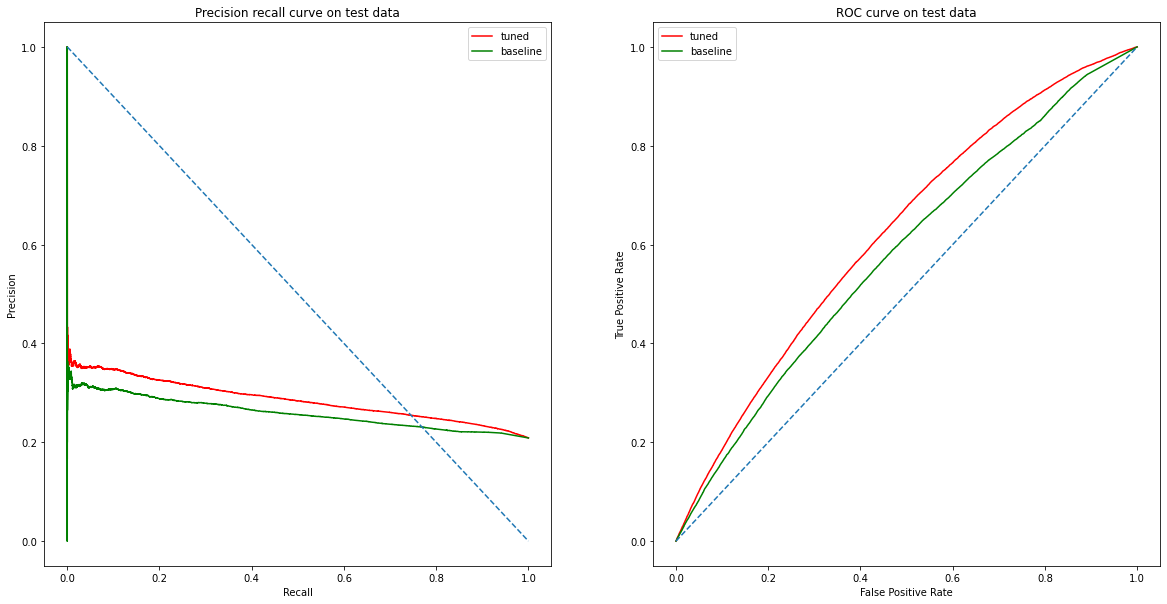

In [29]:
# calculate area under the curve.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[20,10])
axes[0].plot(recall_t, precision_t, "-r", label='tuned')
axes[0].plot(recall_b, precision_b, "-g", label='baseline')
axes[0].plot([0,1],[1,0], '--')
axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
axes[0].set_title('Precision recall curve on test data')
axes[0].legend()

axes[1].plot(fpr_t, tpr_t, "-r", label='tuned')
axes[1].plot(fpr_b, tpr_b, "-g", label='baseline')
axes[1].plot([0, 1], [0, 1],'--')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC curve on test data');
axes[1].legend()

In [30]:
print(f'Area under precision-recall curve: {metrics.auc(recall_t, precision_t)}')
print(f'Area under ROC curve: {metrics.auc(fpr_t, tpr_t)}')

Area under precision-recall curve: 0.2862154638596648
Area under ROC curve: 0.6235354951362277


## Save the model

We might want to re-use the trained model in the future without having to re-train it. To do this, we would need to save the model to disk and load the model when we need it again.

In [31]:
from joblib import dump, load
dump(tuned_model, 'tuned_classifier.pkl')
# to load the model
clf  =  load('tuned_classifier.pkl')


## Regression
---
Predicting the individual record might be challenging, there might be other factors that drives whether a patient get flu consultation on a particular day and we might not have access to those features. 

Instead of predicting daily flu consultation per patient, we might be more interested in questions like: what is the total number of flu consultation by the patient in each month rather than the number of flu consultation per patient per day.

### preprocess

Now let's rework the dataframe such that each row represents the total number of flu consultations of a given month and a given patient.

Hint: In the data, we have daily temperatures, what kind of aggregation we want to do in order to establish a meaningful relationship between temperature and month?  

In [32]:
monthly_df = pd.pivot_table(df,
               values=['temperature','has_flu_consultation'],
               index=['patient_id','month','gender','ethnicity','living_condition'],
               aggfunc={'temperature' : 'mean', 'has_flu_consultation' : 'sum'}
              ).reset_index()

#### prepare inputs for modelling

Like how we have done for classification problems. What kind of preprocessing we need to do?

In [33]:
categorical_cols = ["ethnicity", "living_condition","month"]
model_df = pd.get_dummies(monthly_df, columns=categorical_cols, drop_first=True)

In [34]:
feature_cols = sorted(
    set(model_df.columns) - set(['patient_id','has_flu_consultation','gender'])
)
target_col = "has_flu_consultation"

X=model_df[feature_cols]
y=model_df[target_col]

In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### Model

In [36]:
from sklearn.linear_model import LinearRegression

In [37]:
lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred =  lr.predict(X_test)

### Check performance

Try plotting the actual total consultations against the model predicted total consultations. What is the R2? Does the model perform better than the mean? 

In [38]:
from sklearn.metrics import r2_score

In [39]:
print(f"R2 for the test set is: {r2_score(y_test,y_pred)}")

R2 for the test set is: 0.30722336663518124


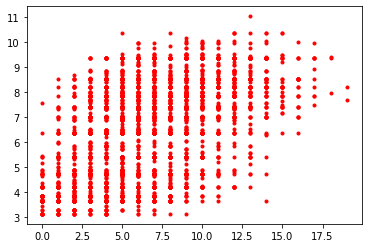

In [40]:
plt.plot(y_test,y_pred,'r.')